### Installing and Importing all the necessary packages

*Hey, We are Siddhant & Pavana and we are participating in Mistral FT Hackathon :3. To begin our Mistral fine-tuning journey, we need to install and import the necessary libraries. This setup ensures we have all the tools required for data manipulation, visualization, and interaction with the Mistral API.*

In [1]:
!pip install mistralai -q

import pandas as pd
import json
from pprint import pprint
import warnings
from google.colab import userdata
import seaborn as sns
import matplotlib.pyplot as plt
import os
from mistralai.client import MistralClient
from mistralai.models.jobs import TrainingParameters, WandbIntegrationIn
import time
from mistralai.models.chat_completion import ChatMessage

warnings.filterwarnings('ignore')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 145.0/145.0 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 3.7 MB/s eta 0:00:00


### Loading and Preparing Data

*We load and prepare the dataset for fine-tuning our Mistral model. This involves splitting the dataset into training (df_train) and evaluation (df_eval) subsets, ensuring a representative distribution for effective model training and validation. As could be seen by the plot, the dataset is balanced in terms of the types of tasks the fine-tuned model should be able to do.*

In [2]:
# Load the dataset
df = pd.read_csv("hf://datasets/starmpcc/Asclepius-Synthetic-Clinical-Notes/synthetic.csv", index_col = "patient_id")
df_train = df.sample(frac=0.2, random_state=42)
df_eval = df.drop(df_train.index).sample(frac=0.01/0.8, random_state=42)

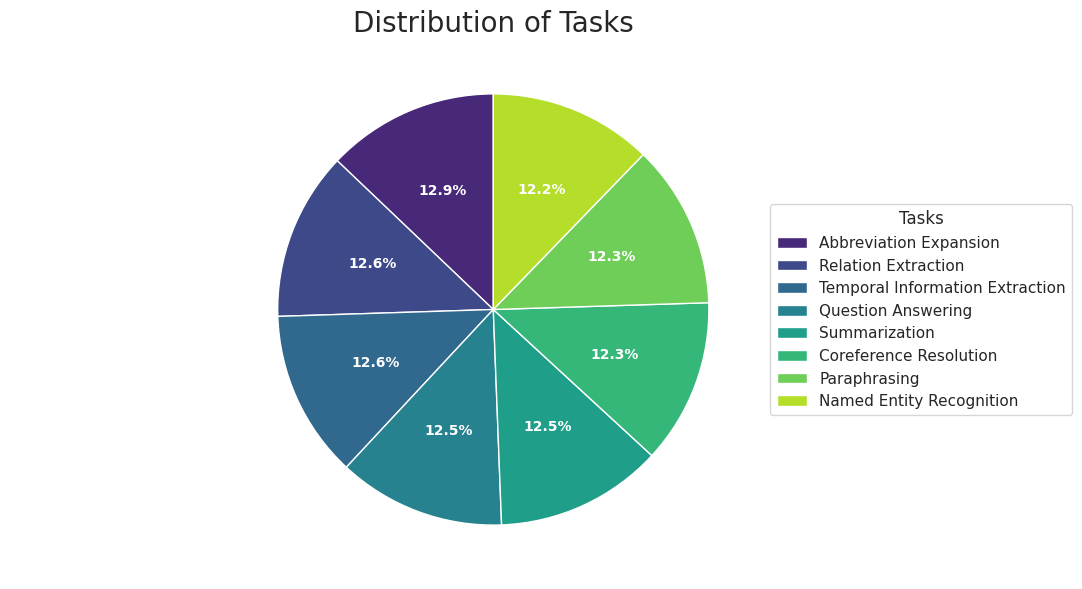

In [44]:
task_counts = df_train['task'].value_counts()
sns.set(style="whitegrid")
colors = sns.color_palette('viridis', len(task_counts))
fig, ax = plt.subplots(figsize=(10, 7), subplot_kw=dict(aspect="equal"))
wedges, texts, autotexts = ax.pie(
    task_counts, labels=task_counts.index, autopct='%1.1f%%', startangle=90, colors=colors,
    textprops=dict(color="w")
)

ax.set_title('Distribution of Tasks', fontsize=20)
ax.legend(wedges, task_counts.index, title="Tasks", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
plt.setp(autotexts, size=10, weight="bold")
plt.setp(texts, size=12)
ax.axis('off')
plt.show()

### Alpaca Prompt Template Definition

*The alpaca_prompt template is defined to structure input for the Mistral model fine-tuning. It sets the context for generating responses based on patient electronic health records and questions posed by healthcare professionals.*

In [ ]:
# Define the Alpaca prompt template
alpaca_prompt = """You are an intelligent clinical language model.
Below is a snippet of patient's electronic health record note and a following instruction with question from healthcare professional.
Write a response that appropriately completes the instruction.
The response should provide the accurate answer to the instruction, while being concise.

### Instruction:
{}

### Patient's Electronic Health Record Note:
{}

### Question:
{}
"""

### Generating Training and Evaluation Data for Mistral Fine-tuning

*To prepare the dataset for fine-tuning the Mistral model, we format training (df_train) and evaluation (df_eval) data with specific instructions and responses. These are then saved into JSONL files for further processing.*

In [4]:
df_train['instruction'] = df_train.apply(
    lambda row: alpaca_prompt.format(row['task'], row['note'], row['question']), axis=1
)
df_eval['instruction'] = df_eval.apply(
    lambda row: alpaca_prompt.format(row['task'], row['note'], row['question']), axis=1
)

df_train.head()

,note,question,answer,task,instruction
patient_id,,,,,
6192,Discharge Summary:\n\nPatient: 81-year-old mal...,What was the reason for the delayed percutaneo...,The reason for the delayed percutaneous corona...,Question Answering,You are an intelligent clinical language model...
14123,Discharge Summary\n\nPatient: [Name]\n\nMedica...,What was the patient's admission and discharge...,The patient's admission diagnosis was palpitat...,Summarization,You are an intelligent clinical language model...
166002,Hospital Course:\n\nThe patient was a 3-month-...,What was the diagnosis of the patient in the g...,The diagnosis of the patient in the given disc...,Question Answering,You are an intelligent clinical language model...
39175,Discharge Summary:\n\nPatient Name: N/A\nAge: ...,Can you provide a simpler explanation of the p...,The patient had a recurring infection in their...,Paraphrasing,You are an intelligent clinical language model...
89551,Hospital Course:\n\nThe patient is a 62-year-o...,What was the duration of the patient's recover...,The discharge summary states that the patient ...,Temporal Information Extraction,You are an intelligent clinical language model...


In [5]:
df_train_formatted = [
    {
        "messages": [
            {"role": "user", "content": row["instruction"]},
            {"role": "assistant", "content": row["answer"]},
        ]
    }
    for index, row in df_train.iterrows()
]

df_eval_formatted = [
    {
        "messages": [
            {"role": "user", "content": row["instruction"]},
            {"role": "assistant", "content": row["answer"]},
        ]
    }
    for index, row in df_eval.iterrows()
]

with open("Training_Asclepius-Synthetic-Clinical-Notes.jsonl", "w") as f:
    for line in df_train_formatted:
        json.dump(line, f)
        f.write("\n")
with open("Testing_Asclepius-Synthetic-Clinical-Notes.jsonl", "w") as f:
    for line in df_eval_formatted:
        json.dump(line, f)
        f.write("\n")

In [6]:
len(df_train), len(df_eval) # COSTED 26.21 Dollars in total for this much data

(31623, 1581)

### Connecting to Mistral and Uploading Data

*To facilitate fine-tuning using Mistral, we establish a connection using your API keys and proceed to upload the prepared JSONL files containing training and evaluation data.*



In [7]:
api_key = userdata.get('MISTRAL_API_KEY') # os.environ.get("MISTRAL_API_KEY")
WANDB_API_KEY = userdata.get('WANDB_API_KEY') #os.environ.get("WANDB_API_KEY")
client = MistralClient(api_key=api_key)

with open("Training_Asclepius-Synthetic-Clinical-Notes.jsonl", "rb") as f:
    Asclepius_chunk_train = client.files.create(file=("Training_Asclepius-Synthetic-Clinical-Notes.jsonl", f))
with open("Testing_Asclepius-Synthetic-Clinical-Notes.jsonl", "rb") as f:
    Asclepius_chunk_eval = client.files.create(file=("Testing_Asclepius-Synthetic-Clinical-Notes.jsonl", f))

### Initiating Model Training with Mistral

*Now Let's start a job to fine-tune the Mistral model (open-mistral-7b) using the uploaded training and evaluation data files. This process involves specifying hyperparameters and integrating with Weights & Biases (WandB) for performance tracking.*

In [8]:
created_jobs = client.jobs.create(
    model="open-mistral-7b",
    training_files=[Asclepius_chunk_train.id],
    validation_files=[Asclepius_chunk_eval.id],
    hyperparameters=TrainingParameters(
        training_steps=100,
        learning_rate=0.0001,
    ),
    integrations=[
        WandbIntegrationIn(
            project="MistralFTHack",
            run_name="Final",
            api_key=WANDB_API_KEY,
        ).dict()
    ],
)

In [9]:
# Took 11 Mins

retrieved_job = client.jobs.retrieve(created_jobs.id)
while retrieved_job.status in ["RUNNING", "QUEUED"]:
    retrieved_job = client.jobs.retrieve(created_jobs.id)
    pprint(retrieved_job)
    print(f"Job is {retrieved_job.status}, waiting 10 seconds")
    time.sleep(10)

DetailedJob(id='ddcad168-dabe-45b8-bfb0-541c6eed8333', hyperparameters=TrainingParameters(training_steps=100, learning_rate=0.0001), fine_tuned_model=None, model='open-mistral-7b', status='RUNNING', job_type='FT', created_at=1719766679, modified_at=1719766679, training_files=['b6abd827-c2a1-460e-b218-e0f7e552efa8'], validation_files=['59cf8ac2-cbe3-47a3-a524-dcbf1a1d0ab8'], object='job', integrations=[WandbIntegration(type='wandb', project='MistralFTHack', name=None, run_name='First')], events=[Event(name='status-updated', data={'status': 'RUNNING'}, created_at=1719766679), Event(name='status-updated', data={'status': 'QUEUED'}, created_at=1719766679)], checkpoints=[], estimated_start_time=None)
Job is RUNNING, waiting 10 seconds
DetailedJob(id='ddcad168-dabe-45b8-bfb0-541c6eed8333', hyperparameters=TrainingParameters(training_steps=100, learning_rate=0.0001), fine_tuned_model=None, model='open-mistral-7b', status='RUNNING', job_type='FT', created_at=1719766679, modified_at=1719766679,

### Retrieving Job Details and Initiating Chat Interaction

*Time to retrieve the details of a previously created job from Mistral, selecting a sample instruction from your evaluation data, and preparing to interact with the fine-tuned model for chat response.*

In [24]:
# Retrieve a jobs
retrieved_jobs = client.jobs.retrieve(created_jobs.id)
pprint(retrieved_jobs)

DetailedJob(id='ddcad168-dabe-45b8-bfb0-541c6eed8333', hyperparameters=TrainingParameters(training_steps=100, learning_rate=0.0001), fine_tuned_model='ft:open-mistral-7b:885d8e28:20240630:ddcad168', model='open-mistral-7b', status='SUCCESS', job_type='FT', created_at=1719766679, modified_at=1719767359, training_files=['b6abd827-c2a1-460e-b218-e0f7e552efa8'], validation_files=['59cf8ac2-cbe3-47a3-a524-dcbf1a1d0ab8'], object='job', integrations=[WandbIntegration(type='wandb', project='MistralFTHack', name=None, run_name='First')], events=[Event(name='status-updated', data={'status': 'SUCCESS'}, created_at=1719767359), Event(name='status-updated', data={'status': 'RUNNING'}, created_at=1719766679), Event(name='status-updated', data={'status': 'QUEUED'}, created_at=1719766679)], checkpoints=[Checkpoint(metrics=Metric(train_loss=0.441276, valid_loss=None, valid_mean_token_accuracy=None), step_number=100, created_at=1719767325), Checkpoint(metrics=Metric(train_loss=0.422325, valid_loss=0.422

In [21]:
test = df_eval['instruction'].sample(n=1, random_state=42).iloc[0]
print(test)

You are an intelligent clinical language model.
Below is a snippet of patient's electronic health record note and a following instruction with question from healthcare professional.
Write a response that appropriately completes the instruction.
The response should provide the accurate answer to the instruction, while being concise.

### Instruction:
Paraphrasing

### Patient's Electronic Health Record Note:
Discharge Summary:

Patient Information:
Name: [REDACTED]
Age: 13
Gender: Female
Admission Date: N/A
Discharge Date: N/A

Hospital Course:
The patient was admitted to our clinic for orthodontic treatment. During the treatment, we observed mesially angulated ectopic impaction of the right second molar. Due to the insufficient buccal surface area, a piston-elastic device was attached to the occlusal surface. The elastic was replaced only once after four weeks, and further check-ups were performed. The tooth exhibited a definite change in the eruption path at two months post-attachment

In [58]:
print(df_eval['instruction'].sample(n=1, random_state=42))

patient_id
55523    You are an intelligent clinical language model...
Name: instruction, dtype: object


In [59]:
pprint(df_eval["answer"][55523])

('The patient, a 13-year-old female, underwent successful orthodontic '
 'treatment for a crooked back tooth using a special device. Regular check-ups '
 'were performed to ensure proper alignment, and the patient is advised to '
 'continue seeing a dentist or orthodontist to maintain the results.')


In [25]:
chat_response = client.chat(
    model=retrieved_jobs.fine_tuned_model,
    messages=[ChatMessage(role='user', content=test)]
)

In [35]:
pprint(json.loads(chat_response.json()))

{'choices': [{'finish_reason': 'stop',
              'index': 0,
              'message': {'content': 'The patient had braces placed to correct '
                                     'the position of a tooth, and it was '
                                     'successful after two months of '
                                     'monitoring. The healthcare professional '
                                     'recommends regular check-ups with a '
                                     'dentist or orthodontist to ensure the '
                                     'tooth stays in its new position.',
                          'name': None,
                          'role': 'assistant',
                          'tool_call_id': None,
                          'tool_calls': None}}],
 'created': 1719767604,
 'id': '5ea725d8643c4aadb380f91f5f640917',
 'model': 'ft:open-mistral-7b:885d8e28:20240630:ddcad168',
 'object': 'chat.completion',
 'usage': {'completion_tokens': 52, 'prompt_tokens': 447, 't

In [55]:
test = df_eval['instruction'].sample(n=1, random_state=0).iloc[0]
print(test)

You are an intelligent clinical language model.
Below is a snippet of patient's electronic health record note and a following instruction with question from healthcare professional.
Write a response that appropriately completes the instruction.
The response should provide the accurate answer to the instruction, while being concise.

### Instruction:
Coreference Resolution

### Patient's Electronic Health Record Note:
Hospital Course:
The patient is a 60-year-old Caucasian woman who presented to the Maxillofacial Surgery Department with a chief complaint of bilateral pre-auricular pain that had persisted for 6 years. She reported a history of seeking care from different dental professionals without any improvement. During the clinical examination, limited mouth opening, clicking in the right TMJ, and intense bilateral articular pain were observed. TMJ radiography revealed radiopaque images in both TMJs and the CT scan confirmed the presence of loose bodies in TMJ bilaterally, which meas

In [57]:
print(df_eval['instruction'].sample(n=1, random_state=0))

patient_id
28579    You are an intelligent clinical language model...
Name: instruction, dtype: object


In [56]:
pprint(df_eval["answer"][28579])

('The histopathological examination confirmed the diagnosis of bilateral '
 'synovial chondromatosis based on the presence of fragments of lamellar bone '
 'tissue in continuity with fibrocartilaginous tissue surrounded by fibrous '
 'connective tissue.')


In [47]:
chat_response = client.chat(
    model=retrieved_jobs.fine_tuned_model,
    messages=[ChatMessage(role='user', content=test)]
)
pprint(json.loads(chat_response.json()))

{'choices': [{'finish_reason': 'stop',
              'index': 0,
              'message': {'content': 'The histopathological examination of '
                                     'fragments of lamellar bone tissue '
                                     'surrounded by fibrous connective tissue '
                                     'confirmed the diagnosis of bilateral '
                                     'synovial chondromatosis.',
                          'name': None,
                          'role': 'assistant',
                          'tool_call_id': None,
                          'tool_calls': None}}],
 'created': 1719768154,
 'id': '17f50d0b3c044433a63e604074bee80d',
 'model': 'ft:open-mistral-7b:885d8e28:20240630:ddcad168',
 'object': 'chat.completion',
 'usage': {'completion_tokens': 36, 'prompt_tokens': 619, 'total_tokens': 655}}
